In [1]:
import math
import pandas as pd
from statsbombpy import sb
from mplsoccer import VerticalPitch

In [2]:
df = sb.events(match_id=3869685)

In [3]:
df[['x', 'y']] = df['location'].apply(pd.Series)

In [4]:
df = df[df['team'] == 'Argentina']

In [5]:
df['newsecond'] = 60 * df['minute'] + df['second']

In [6]:
df = df.sort_values(by=['newsecond'])

In [7]:
df['newsecond']

0          0
3          0
14        16
2390      17
1277      17
        ... 
4242    7456
4406    7497
4287    7510
4244    7557
4404    7558
Name: newsecond, Length: 2372, dtype: int64

In [8]:
df['passer'] = df['player_id']
df['recipient'] = df['passer'].shift(-1)

In [9]:
passes_df = df[df['type'] == 'Pass']

In [10]:
passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")

C:\Users\knich\AppData\Local\Temp\ipykernel_28732\2602487714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")


In [11]:
passes_df['pass_outcome']

14      Successful
15      Successful
16      Successful
17      Successful
18      Successful
           ...    
1268    Successful
1269    Successful
1270    Successful
1272    Incomplete
1273    Successful
Name: pass_outcome, Length: 693, dtype: object

In [12]:
completions = passes_df[passes_df['pass_outcome'] == 'Successful']

In [13]:
sub_df = df[df['type'] == 'Substitution']
first_sub = sub_df['newsecond'].min()

In [14]:
first_sub

3831

In [15]:
if first_sub <= (60*40):
    first_sub = 60*45

In [16]:
completions = completions[completions['newsecond'] < first_sub]

In [17]:
completions.shape

(317, 99)

In [18]:
average_loc_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count']})

In [19]:
average_loc_and_count.columns = ['x', 'y', 'count']

In [20]:
average_loc_and_count.head()

,x,y,count
passer,,,
2995.0,79.884000,11.448000,25
3090.0,38.279545,23.350000,44
5503.0,71.588889,51.096296,27
5507.0,58.567857,7.335714,28
6909.0,12.641667,43.966667,12


In [21]:
passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()

In [22]:
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

In [25]:
passes_between = passes_between.merge(average_loc_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(average_loc_and_count, left_on='recipient', right_index=True, suffixes=['', '_end'])

In [26]:
passes_between

,passer,recipient,pass_count,x,y,count,x_end,y_end,count_end
0,2995.0,2995.0,2,79.884000,11.448000,25,79.884000,11.448000,25
9,3090.0,2995.0,4,38.279545,23.350000,44,79.884000,11.448000,25
17,5503.0,2995.0,4,71.588889,51.096296,27,79.884000,11.448000,25
26,5507.0,2995.0,7,58.567857,7.335714,28,79.884000,11.448000,25
32,6909.0,2995.0,2,12.641667,43.966667,12,79.884000,11.448000,25
...,...,...,...,...,...,...,...,...,...
14,3090.0,20572.0,12,38.279545,23.350000,44,33.905128,53.346154,39
21,5503.0,20572.0,1,71.588889,51.096296,27,33.905128,53.346154,39
35,6909.0,20572.0,4,12.641667,43.966667,12,33.905128,53.346154,39
43,7797.0,20572.0,6,59.159459,59.248649,37,33.905128,53.346154,39


In [27]:
passes_between = passes_between[passes_between['pass_count'] >= 4]

In [28]:
def pass_line_template(ax, x, y, end_x, end_y, line_color):
    ax.annotate(
        '',
    xy=(end_y, end_x),
    xytext=(y, x),
    zorder=1,
    arrowprops=dict(arrowstyle='-|>', linewidth=4, color=line_color, alpha=.85)
    )

def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y-y, end_x-x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)

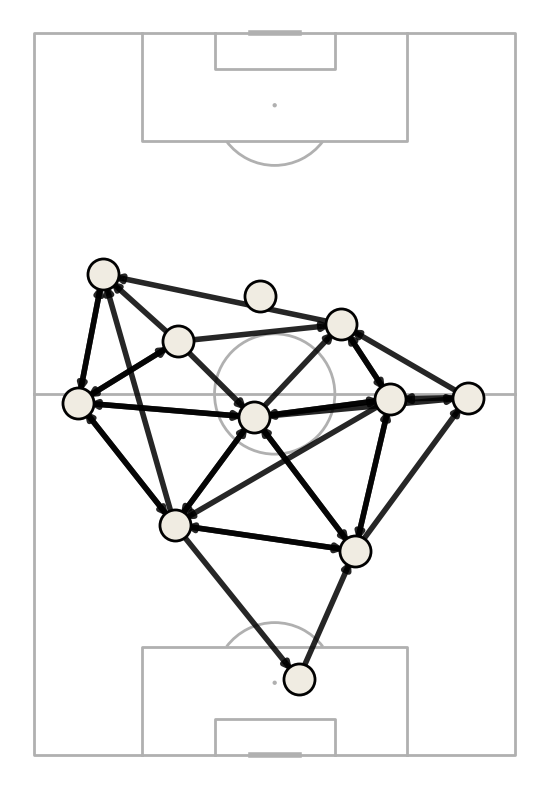

In [30]:
pitch = VerticalPitch(pitch_type='statsbomb')
fig, ax = pitch.draw(figsize=(12,8))

for index, row in passes_between.iterrows():
    pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], 'black')
    
pitch.scatter(
    average_loc_and_count.x, average_loc_and_count.y, s=500,
    color='#f0ece2', edgecolors='#010101', linewidth=2, alpha=1, ax=ax, zorder=2)